<img src="http://xarray.pydata.org/en/stable/_static/dataset-diagram-logo.png" align="right" width="30%">

# Grouped Computations

In this lesson, we discuss how to do scientific computations with defined "groups" of data
within our xarray objects. Our learning goals are as follows:

- Perform "split / apply / combine" workflows in Xarray using `groupby`,
  including
  - reductions within groups
  - transformations on groups
- Use `resample` to change the time frequency of the data


In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# don't expand data by default
xr.set_options(display_expand_data=False)

%config InlineBackend.figure_format='retina'

## Example Dataset

First we load a dataset. We will use the
[NOAA Extended Reconstructed Sea Surface Temperature (ERSST) v5](https://www.ncdc.noaa.gov/data-access/marineocean-data/extended-reconstructed-sea-surface-temperature-ersst-v5)
product, a widely used and trusted gridded compilation of of historical data
going back to 1854.

In [2]:
ds = xr.tutorial.load_dataset("ersstv5")
ds

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 624, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1970-01-01 1970-02-01 ... 2021-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
    sst        (time, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2022-06-07

## Groupby

Xarray copies Pandas' very useful groupby functionality, enabling the "split /
apply / combine" workflow on xarray DataArrays and Datasets.

Let's examine a timeseries of SST at
a single point.


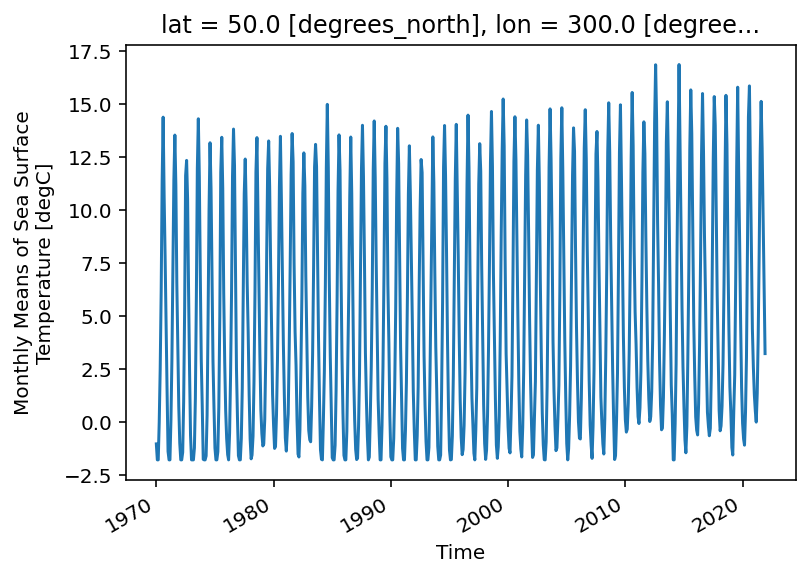

In [3]:
ds.sst.sel(lon=300, lat=50).plot();

As we can see from the plot, the timeseries at any one point is totally
dominated by the seasonal cycle. We would like to remove this seasonal cycle
(called the "climatology") in order to better see the long-term variaitions in
temperature. We can accomplish this using **groupby**.

Before moving forward, we note that xarray correctly parsed the time index,
resulting in a Pandas datetime index on the time dimension.


In [4]:
ds.time

<xarray.DataArray 'time' (time: 624)>
1970-01-01 1970-02-01 1970-03-01 1970-04-01 ... 2021-10-01 2021-11-01 2021-12-01
Coordinates:
  * time     (time) datetime64[ns] 1970-01-01 1970-02-01 ... 2021-12-01
Attributes:
    long_name:        Time
    delta_t:          0000-01-00 00:00:00
    avg_period:       0000-01-00 00:00:00
    prev_avg_period:  0000-00-07 00:00:00
    standard_name:    time
    axis:             T
    actual_range:     [19723. 81204.]

The syntax of Xarray's groupby is almost identical to Pandas.


In [5]:
?ds.groupby

Signature:
ds.groupby(
    group,
    squeeze: 'bool' = True,
    restore_coord_dims: 'bool' = None,
)
Docstring:
Returns a GroupBy object for performing grouped operations.

Parameters
----------
group : str, DataArray or IndexVariable
    Array whose unique values should be used to group this array. If a
    string, must be the name of a variable contained in this dataset.
squeeze : bool, optional
    If "group" is a dimension of any arrays in this dataset, `squeeze`
    controls whether the subarrays have a dimension of length 1 along
    that dimension or if the dimension is squeezed out.
restore_coord_dims : bool, optional
    If True, also restore the dimension order of multi-dimensional
    coordinates.

Returns
-------
grouped
    A `GroupBy` object patterned after `pandas.GroupBy` that can be
    iterated over in the form of `(unique_value, grouped_array)` pairs.

Examples
--------
Calculate daily anomalies for daily data:

>>> da = xr.DataArray(
...     np.linspace(0, 1826, n

### Identifying groups

The most important argument is `group`: this defines the unique values or labels we will
us to "split" the data for grouped analysis. We can pass either a DataArray or a
name of a variable in the dataset. Let's first use a DataArray. 

Just like with
Pandas, we can use the time index to extract specific components of dates and
times. Xarray uses a special syntax for this `.dt`, called the
[DatetimeAccessor](https://xarray.pydata.org/en/stable/generated/xarray.core.accessor_dt.DatetimeAccessor.html?highlight=DatetimeAccessor). See the [documentation](https://xarray.pydata.org/en/stable/user-guide/time-series.html#datetime-components) for more


In [6]:
ds.time.dt

In [7]:
ds.time.dt.month

<xarray.DataArray 'month' (time: 624)>
1 2 3 4 5 6 7 8 9 10 11 12 1 2 3 4 5 ... 8 9 10 11 12 1 2 3 4 5 6 7 8 9 10 11 12
Coordinates:
  * time     (time) datetime64[ns] 1970-01-01 1970-02-01 ... 2021-12-01

In [8]:
ds.time.dt.year

<xarray.DataArray 'year' (time: 624)>
1970 1970 1970 1970 1970 1970 1970 1970 ... 2021 2021 2021 2021 2021 2021 2021
Coordinates:
  * time     (time) datetime64[ns] 1970-01-01 1970-02-01 ... 2021-12-01

### Split step

We can use these arrays in a groupby operation:


In [9]:
gb = ds.groupby(ds.time.dt.month)
gb

DatasetGroupBy, grouped over 'month'
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

Xarray also offers a more concise syntax when the variable you're grouping on is
already present in the dataset. This is identical to the previous line:


In [10]:
gb = ds.groupby("time.month")
gb

DatasetGroupBy, grouped over 'month'
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

`gb` is a DatasetGroupBy object. It represents a GroupBy operation and helpfully tells us the unique "groups" or labels found during the split step.


<div class="alert alert-info">
    Xarrays' computation methods (groupby, groupby_bins, rolling, coarsen, weighted) all return special objects that represent the basic underlying computation pattern. For e.g. `gb` above is a `DatasetGroupBy` object that represents monthly groupings of the data in `ds` . It is usually helpful to save and reuse these objects for multiple operations (e.g. a mean and standard deviation calculation).
</div>

### Apply & Combine

Now that we have groups defined, it's time to "apply" a calculation to the
group. Like in Pandas, these calculations can either be:

- _aggregation_ or _reduction_: reduces the size of the group
- _transformation_: preserves the group's full size

At then end of the apply step, xarray will automatically combine the aggregated
/ transformed groups back into a single object.

#### Aggregations or Reductions

Most commonly, we want to perform a reduction operation like `sum` or `mean` on our groups. Xarray conveniently provides these reduction methods on Groupby objects for both [DataArrays and Datasets](https://xarray.pydata.org/en/stable/api.html#groupby-objects).

Here we calculate the monthly mean.

In [11]:
ds_mm = gb.mean()
ds_mm

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, month: 12, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (month, nbnds) float64 9.969e+36 9.969e+36 ... 9.969e+36
    sst        (month, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan

So we did what we wanted to do: calculate the climatology at every point in the
dataset. Let's look at the data a bit.

_Climatology at a specific point in the North Atlantic_


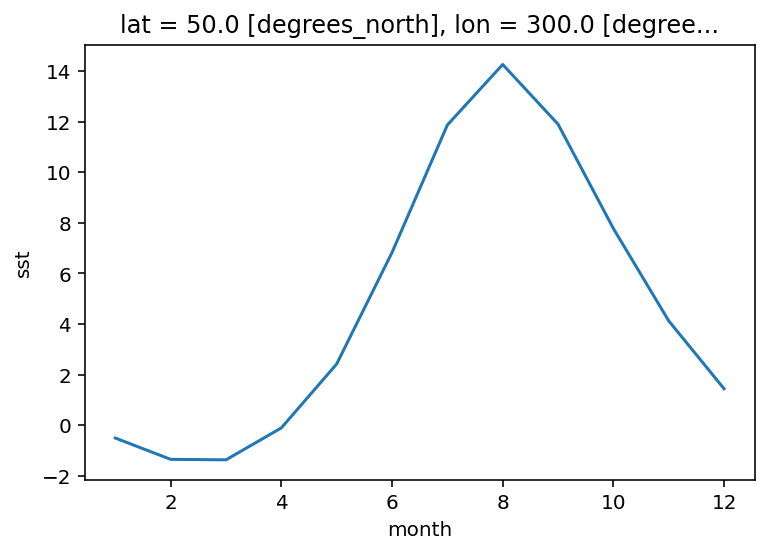

In [12]:
ds_mm.sst.sel(lon=300, lat=50).plot();

_Zonal Mean Climatology_


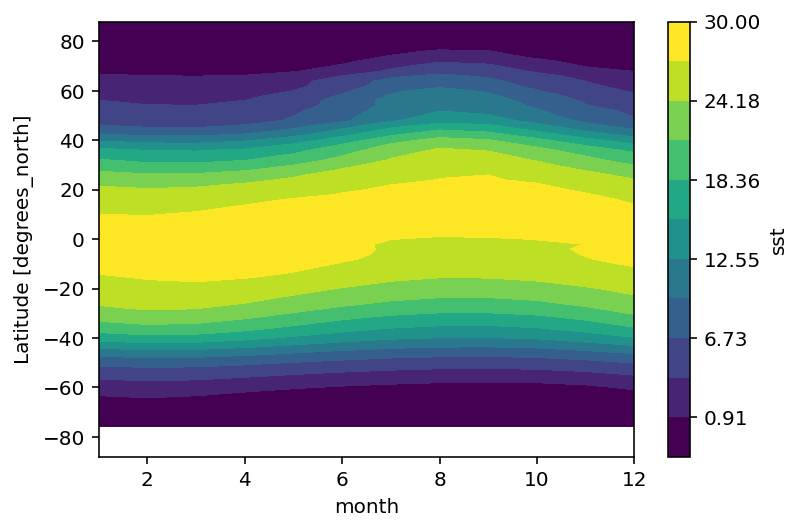

In [13]:
ds_mm.sst.mean(dim="lon").plot.contourf(x="month", levels=12, vmin=-2, vmax=30);

_Difference between January and July Climatology_


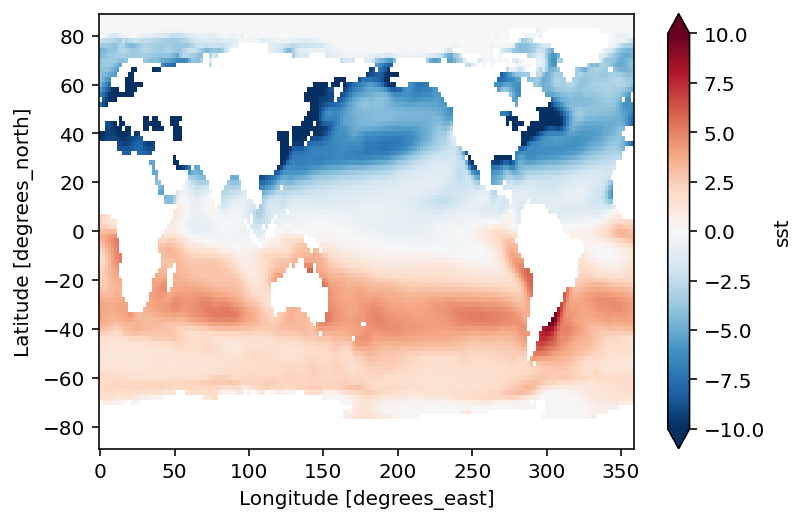

In [14]:
(ds_mm.sst.sel(month=1) - ds_mm.sst.sel(month=7)).plot(vmax=10);

#### Custom Aggregations

The most fundamental way to apply a function and combine the results together to use the `.map` method.

In [ ]:
?gb.map

`.map` accepts as its argument a function that expects and returns xarray
objects. We define a custom function. This function takes a single argument--the
group dataset--and returns a new dataset to be combined:

In [ ]:
def time_mean(a):
    return a.mean(dim="time")


gb.map(time_mean)

This is identical to `gb.mean()`

#### Apply by iteration

We can manually iterate over the group. The
iterator returns the key (group name) and the value (the actual dataset
corresponding to that group) for each group.


You could apply any function you want in the loop but you would have to manually [combine](https://docs.xarray.dev/en/stable/user-guide/combining.html) the results together.

In [ ]:
for group_name, group_ds in gb:
    # stop iterating after the first loop
    break
print(group_name)
group_ds

#### Transformations

Now we want to _remove_ this climatology from the dataset, to examine the
residual, called the _anomaly_, which is the interesting part from a climate
perspective. Removing the seasonal climatology is a perfect example of a
transformation: it operates over a group, but doesn't change the size of the
dataset. Here is one way to code it


In [ ]:
def remove_time_mean(x):
    return x - x.mean(dim="time")


ds_anom = ds.groupby("time.month").map(remove_time_mean)
ds_anom

Xarray makes these sorts of transformations easy by supporting _groupby
arithmetic_. This concept is easiest explained with an example:


In [ ]:
gb = ds.groupby("time.month")
ds_anom = gb - gb.mean()
ds_anom

Now we can view the climate signal without the overwhelming influence of the
seasonal cycle.

_Timeseries at a single point in the North Atlantic_


In [ ]:
ds_anom.sst.sel(lon=300, lat=50).plot();

_Difference between Jan. 1 2018 and Jan. 1 1970_


In [ ]:
(ds_anom.sel(time="2018-01-01") - ds_anom.sel(time="1970-01-01")).sst.plot();

### Exercise

Using `groupby`, plot the annual mean time series of SST at 300°E, 50°N

In [ ]:
ds.groupby("time.year").mean().sst.sel(lon=300, lat=50).plot();

## Resample

Resampling means changing the time frequency of data, usually reducing to a coarser frequency: e.g. converting daily frequency data to monthly frequency data using `mean` to reduce the values. This operation can be thought of as a groupby operation where each group is a single month of data. Resampling can be applied only to time-index dimensions. 

First note that `ds_anom` has data at monthly frequency (i.e. one point every month).

In [ ]:
ds_anom.time

Here we compute the five-year mean along the `time` dimension by passing `time='5Y'`. `'5Y'` is a special frequency string. Xarray uses pandas to convert such a frequency string to a groupby operation. See the [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases) for how to specify a different frequency.

In [ ]:
resample_obj = ds_anom.resample(time="5Y")
resample_obj

<div class="alert alert-info">
    <strong>Note:</strong> <code>resample</code> only works with proper datetime64 coordinate labels. Note the `dtype` of `time` in the repr above.
</div>

Resampling objects are exactly like groupby objects and allow reductions, iteration, etc.

In [ ]:
ds_anom_resample = resample_obj.mean()
ds_anom_resample

In [ ]:
for label, group in resample_obj:
    break
print(label, "\n\n", group)

In [ ]:
ds_anom.sst.sel(lon=300, lat=50).plot()
ds_anom_resample.sst.sel(lon=300, lat=50).plot(marker="o");

### Exercise

Using `resample`, plot the annual mean time series of SST at 300°E, 50°N.

Compare this output to the groupby output. What differences do you see?

In [ ]:
resampled = ds.resample(time='Y').mean().sst.sel(lon=300, lat=50)
resampled.plot();

Let's compare the grouped and resampled outputs.


1. Note the different dimension names: when grouped, `time` is renamed to `year`. When resampled, the `time` dimension name is preserved
2. The values for `year` are integers, while those for `resampled.time` are timestamps, similar to the input dataset
3. But all values are equal

In [ ]:
from IPython.display import display_html

grouped = ds.groupby("time.year").mean().sst.sel(lon=300, lat=50)
display_html(grouped)
display_html(resampled)

In [ ]:
np.array_equal(grouped.data, resampled.data)

## Going further

1. See the documentation on [groupby](https://docs.xarray.dev/en/stable/user-guide/groupby.html) and [resample](https://docs.xarray.dev/en/stable/user-guide/time-series.html#resampling-and-grouped-operations)
2. Follow the tutorial on [high-level computation patterns](https://tutorial.xarray.dev/intermediate/01-high-level-computation-patterns.html)